Loading data from 'forestfires.csv'...
Dataset loaded successfully. Shape: (517, 13)
Preparing data for training...
Class distribution:
fire
1    270
0    247
Name: count, dtype: int64
Percentage of fire cases: 52.22%
Features used: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
Training set size: 413, Test set size: 104

TRAINING AND EVALUATING MODELS

Training Random Forest...

Random Forest:
--------------------------------------------------
Metric          Score     
--------------------------------------------------
Accuracy        0.6346
Precision       0.6481
Recall          0.6481
F1 Score        0.6481
Specificity     0.6200
AUC-ROC         0.7070
NCC Score       0.3771
--------------------------------------------------

Training XGBoost...

XGBoost:
--------------------------------------------------
Metric          Score     
--------------------------------------------------
Accuracy        0.6635
Precision       0.6727
Recall          0.6852
F1 Score  

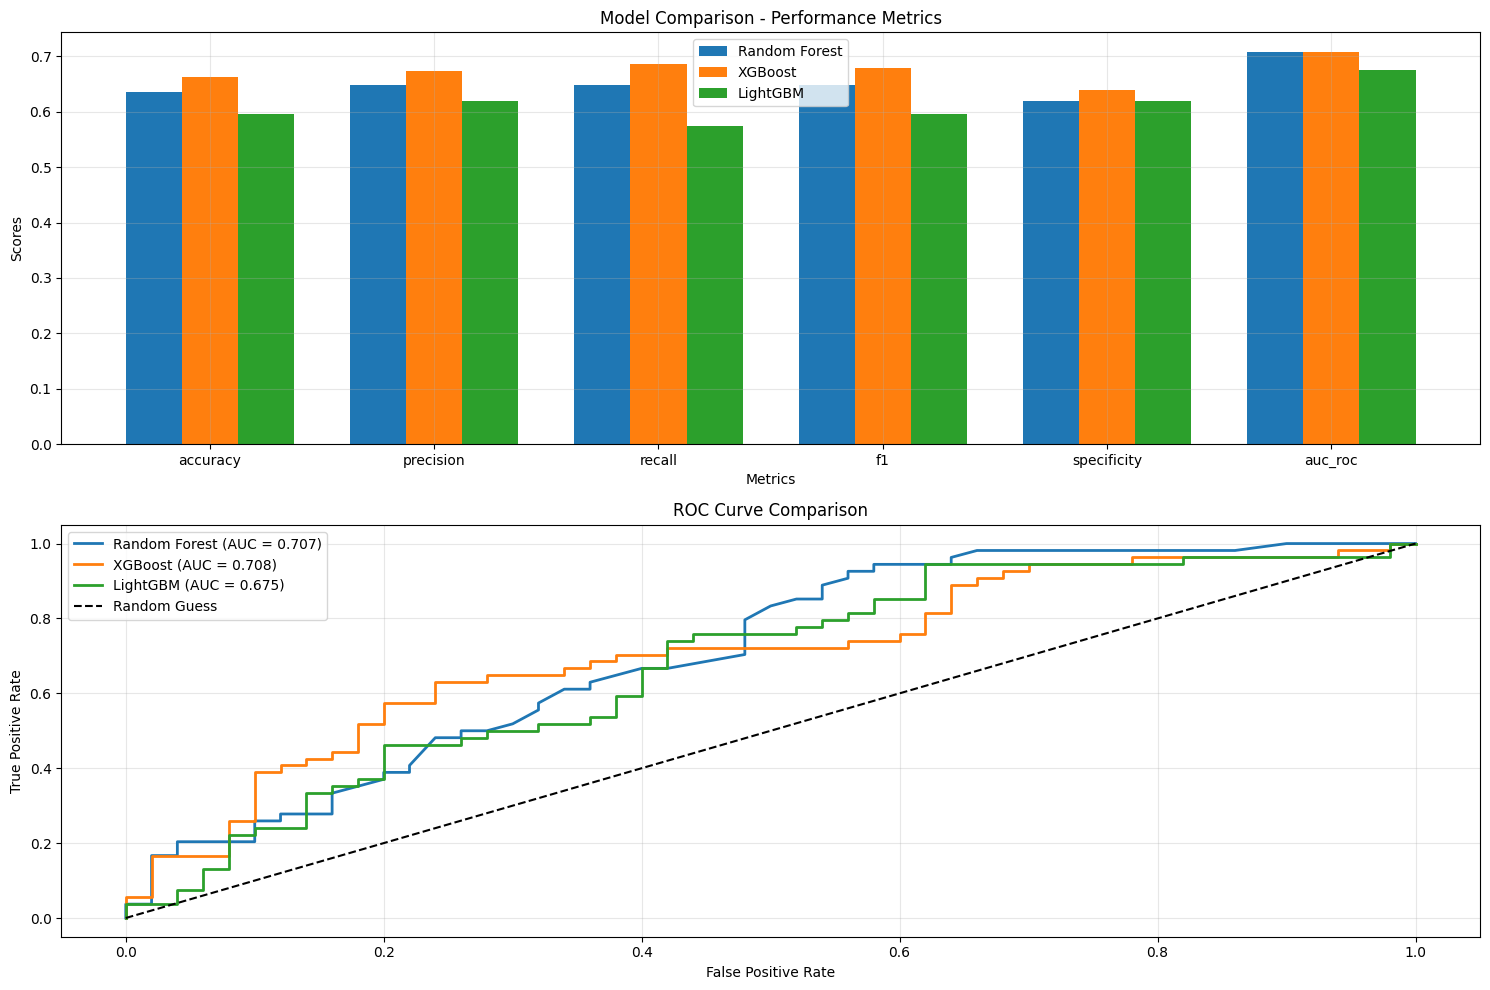


SAVING THE BEST MODEL
Best model (XGBoost) saved to 'model' directory.
Files saved:
- best_model.pkl (trained model)
- scaler.pkl (feature scaler)
- feature_names.pkl (list of feature names)

FINAL RECOMMENDATION
Based on comprehensive evaluation, the XGBoost model
is recommended for deployment as it achieved the best balanced
performance across multiple metrics, particularly the F1 score
which balances precision and recall effectively.

Detailed Comparison Table:
               ACCURACY  PRECISION      F1  RECALL  SPECIFICITY  AUC_ROC  \
Random Forest    0.6346     0.6481  0.6481  0.6481         0.62   0.7070   
XGBoost          0.6635     0.6727  0.6789  0.6852         0.64   0.7078   
LightGBM         0.5962     0.6200  0.5962  0.5741         0.62   0.6752   

                  NCC  
Random Forest  0.3771  
XGBoost        0.3334  
LightGBM       0.3011  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, precision_score, f1_score, 
                            recall_score, roc_auc_score, roc
                            _curve)
import joblib
import os
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
TRAINING_DATA_FILE = 'forestfires.csv' 
MODEL_DIR = 'model'

# --- 1. Load the Dataset ---
print(f"Loading data from '{TRAINING_DATA_FILE}'...")
try:
    df = pd.read_csv(TRAINING_DATA_FILE)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{TRAINING_DATA_FILE}' was not found.")
    exit()

# --- 2. Prepare the Data for Training ---
print("Preparing data for training...")

# Convert to binary classification problem
df['fire'] = (df['area'] > 0).astype(int)
print(f"Class distribution:\n{df['fire'].value_counts()}")
print(f"Percentage of fire cases: {df['fire'].mean()*100:.2f}%")

# Drop original text-based and target columns
df = df.drop(columns=['month', 'day', 'area'])

# Features and target
X = df.drop('fire', axis=1)
y = df['fire']

feature_names = list(X.columns)
print(f"Features used: {feature_names}")

# For tree-based models, scaling is not strictly necessary, but we'll do it for consistency
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- Function to calculate all metrics ---
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate comprehensive evaluation metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix for specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # AUC-ROC if probabilities are available
    if y_pred_proba is not None:
        metrics['auc_roc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
        metrics['ncc'] = np.corrcoef(y_true, y_pred_proba[:, 1])[0, 1]
    else:
        metrics['auc_roc'] = 0
        metrics['ncc'] = 0
    
    return metrics

# --- Function to display model scores in table format ---
def display_model_scores(model_name, metrics):
    """Display model scores in a formatted table"""
    print(f"\n{model_name}:")
    print("-" * 50)
    print(f"{'Metric':<15} {'Score':<10}")
    print("-" * 50)
    print(f"{'Accuracy':<15} {metrics['accuracy']:.4f}")
    print(f"{'Precision':<15} {metrics['precision']:.4f}")
    print(f"{'Recall':<15} {metrics['recall']:.4f}")
    print(f"{'F1 Score':<15} {metrics['f1']:.4f}")
    print(f"{'Specificity':<15} {metrics['specificity']:.4f}")
    print(f"{'AUC-ROC':<15} {metrics['auc_roc']:.4f}")
    print(f"{'NCC Score':<15} {metrics['ncc']:.4f}")
    print("-" * 50)

# --- 3. Train and Evaluate All Models ---
# Use optimized parameters to reduce warnings and improve performance
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        eval_metric='logloss',
        scale_pos_weight=sum(y == 0) / sum(y == 1)  # Handle class imbalance
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        verbose=-1,  # Suppress LightGBM warnings
        force_col_wise=True,  # Prevent col-wise threading warnings
        class_weight='balanced'
    )
}

results = {}
trained_models = {}

print("\n" + "="*60)
print("TRAINING AND EVALUATING MODELS")
print("="*60)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
    results[model_name] = metrics
    trained_models[model_name] = model
    
    # Display scores for this model
    display_model_scores(model_name, metrics)

# --- 4. Display All Model Scores ---
print("\n" + "="*60)
print("ALL MODEL SCORES SUMMARY")
print("="*60)

for model_name in results.keys():
    display_model_scores(model_name, results[model_name])

# --- 5. Determine Best Model ---
print("\n" + "="*60)
print("BEST MODEL ANALYSIS")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T

# Find best model for each metric
best_models = {}
for metric in ['accuracy', 'precision', 'f1', 'recall', 'specificity', 'auc_roc', 'ncc']:
    best_model = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    best_models[metric] = (best_model, best_score)
    print(f"Best {metric.upper():<12}: {best_model} ({best_score:.4f})")

# Determine overall best model (based on F1 score as it balances precision and recall)
overall_best_model = comparison_df['f1'].idxmax()
print(f"\nOverall Best Model: {overall_best_model} (based on F1 Score)")

# --- 6. Plot Comparison Graph ---
print("\n" + "="*60)
print("MODEL COMPARISON VISUALIZATION")
print("="*60)

# Create comparison plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'auc_roc']
models_list = list(results.keys())

plt.figure(figsize=(15, 10))

# Plot 1: Bar chart comparison
plt.subplot(2, 1, 1)
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, model_name in enumerate(models_list):
    scores = [results[model_name][metric] for metric in metrics_to_plot]
    plt.bar(x + i*width, scores, width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Comparison - Performance Metrics')
plt.xticks(x + width, metrics_to_plot)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: ROC Curves
plt.subplot(2, 1, 2)
for model_name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[model_name]["auc_roc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'model_comparison.png'))
plt.show()

# --- 7. Save the Best Model ---
print("\n" + "="*60)
print("SAVING THE BEST MODEL")
print("="*60)

# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the best model and related files
best_model = trained_models[overall_best_model]
joblib.dump(best_model, os.path.join(MODEL_DIR, 'best_model.pkl'))
joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.pkl'))
joblib.dump(feature_names, os.path.join(MODEL_DIR, 'feature_names.pkl'))

print(f"Best model ({overall_best_model}) saved to '{MODEL_DIR}' directory.")
print("Files saved:")
print("- best_model.pkl (trained model)")
print("- scaler.pkl (feature scaler)")
print("- feature_names.pkl (list of feature names)")

# --- 8. Final Recommendation ---
print("\n" + "="*60)
print("FINAL RECOMMENDATION")
print("="*60)
print(f"Based on comprehensive evaluation, the {overall_best_model} model")
print("is recommended for deployment as it achieved the best balanced")
print("performance across multiple metrics, particularly the F1 score")
print("which balances precision and recall effectively.")

# Show detailed comparison table
print("\nDetailed Comparison Table:")
comparison_display = comparison_df.copy()
comparison_display.columns = [col.upper() for col in comparison_display.columns]
print(comparison_display.round(4))